Version info
>v011 - deleted testing codes

>v013 - manipulating multiple beta(This version works properly)

Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import pymc3 as pm
import scipy.optimize as so

import datetime as dt

#from pymc3 import Model, sample, find_MAP, summary
#from pymc3 import NUTS, Metropolis, Slice
#from pymc3 import Normal, Uniform
#from scipy import optimize
#from pymc3 import traceplot

In [2]:
debug = False

In [3]:
debug = True

Loading and preprocessing barley data(explatory variables)

In [4]:
#Loading data file
#barley_raw = pd.read_csv('./data/barley_01.csv', sep=',', header=0, index_col=0)
barley_raw = pd.read_table('./data/barley_01.txt', sep='\t', header=0, index_col=0)

#Explorering data
if debug:
    barley_raw.head()
    barley_raw.info()

#Transposing
barley_t = barley_raw.transpose()
if debug:
    print(barley_t.iloc[0:5, 0:5])

# 39, 96, 116, 103 th DH lines removed for marker mapping(146 marker mappings)
# and also 33 th DH line should be removed for QTL analysis(145 lines)
barley = barley_t.drop(labels=barley_t.index[[39-1, 96-1, 116-1, 103-1, 33-1]])

barley.head()

#Imputed missing(-) to 1 temporarily, I'll use automatic imputation feature of PyMC
#[http://stronginference.com/missing-data-imputation.html]
barley.replace(['A', 'B', '-'], [0,1,1], inplace=True)

if debug:
    print(barley.ix[:6,10:20])

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, *dRpg1 to *MWG632
Columns: 150 entries, 1 to 150
dtypes: object(150)
memory usage: 149.8+ KB
  *dRpg1 *iPgd1A *BCD129 *iEst5 *Prx1A
1      B       B       B      B      B
2      A       A       A      A      A
3      A       A       A      A      A
4      A       A       A      A      A
5      A       A       A      A      A
   *MWG511  *MWG626  *VAtp57A  *MWG571D  *MWG889B  *ABC310B  *PSR129  *ABC253  \
1        1        0         0         0         0         0        0        1   
2        1        1         1         1         1         1        1        1   
3        0        0         0         0         1         1        1        1   
4        1        1         1         1         1         1        1        1   
5        1        1         0         0         0         1        1        1   
6        1        1         1         1         1         1        1        1   

   *ABG608  *WG380A  
1        1        1  
2  

Loading and preprocessing heading data(response variable)

In [5]:
heading_raw = pd.read_table('./data/HED_01.txt', sep='\t', header=0, index_col=0)
heading_raw.replace([-9999.0, -9999], [float('NaN'), float('NaN')], inplace=True)
if debug:
    print(heading_raw.head())
    
# Averaging 'days to heading' over all environments for each line.
heading = heading_raw.mean(skipna=True)
if debug:
    heading.head()



                  1   2   3     4   5     6     7   8     9    10  ...    141  \
*AK93~plm3~1   56.5  54  59  54.5  55  54.5  55.5  55  55.5  54.5  ...   57.5   
*OR92~osu2~2    NaN NaN NaN  94.0 NaN   NaN  97.0  94   NaN   NaN  ...    NaN   
*WA92~wsu2~3    NaN NaN NaN  78.0 NaN   NaN  78.0  76   NaN   NaN  ...    NaN   
*WA93~wsu3~4   57.0  57  59  56.0  58  58.0  58.0  56  58.0  56.0  ...   57.0   
*AB92b~ap12~6  65.0  67  64  65.0  64  66.0  67.0  67  67.0  65.0  ...   64.0   

               142  143  144   145  146   147   148  149   150  
*AK93~plm3~1    56   53   54  53.5   55  55.5  54.5   53  55.5  
*OR92~osu2~2    94   94  NaN  94.0   94   NaN   NaN  NaN  94.0  
*WA92~wsu2~3    76   75  NaN  77.0   76   NaN   NaN  NaN  74.0  
*WA93~wsu3~4    57   56   58  57.0   57  57.0  59.0   56  57.0  
*AB92b~ap12~6   64   63   64  64.0   64  65.0  66.0   65  64.0  

[5 rows x 145 columns]


Testing with multivariate beta

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '5576' (I am process '8628')


Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta2
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta3
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 65.1 sec00:23:54.321522


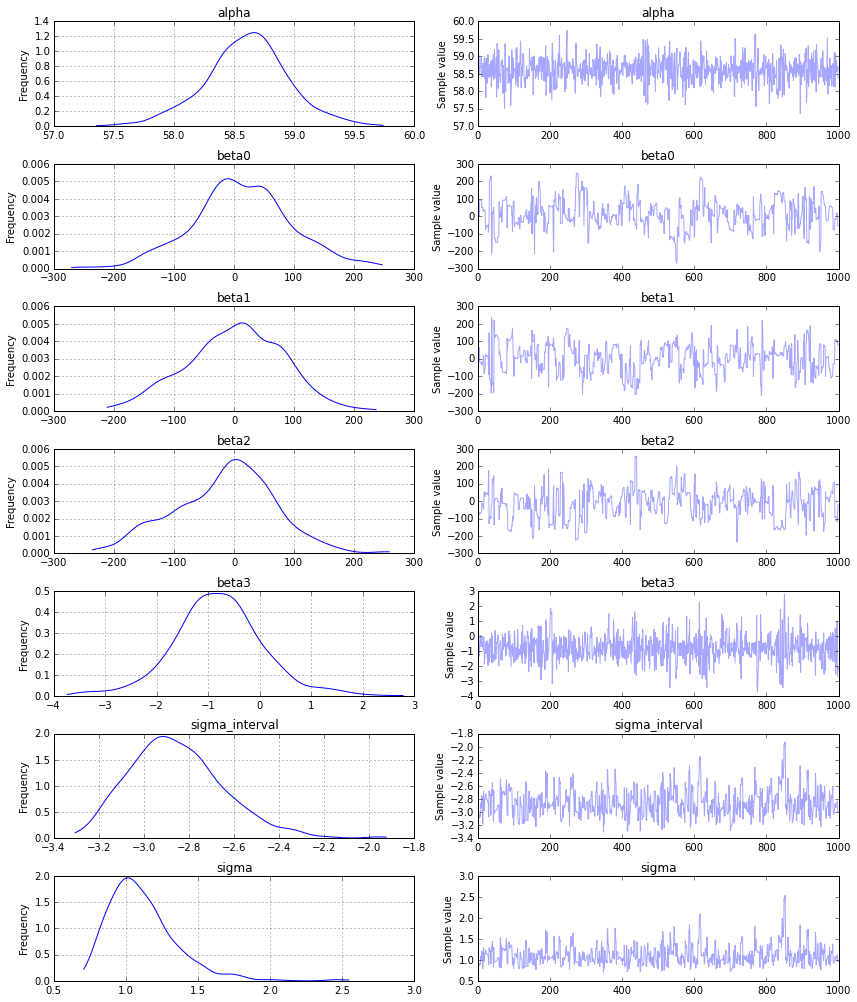

In [ ]:
num_n = 20 #max 144(total 145 rows)
num_p = 4  #max 126(total 127 columns)
X = barley.ix[:num_n,:num_p]
Y = heading.ix[:num_n]

niter = 1000
beta = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X.ix[:,i]
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())



In [29]:
for i in range(num_p):
    print(i+1)

1
2
